In [43]:
from gcm import GCM
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import normaltest

import scipy.stats as stats
from scipy.stats import zscore

from IPython.display import display
from sklearn.preprocessing import PowerTransformer

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_squared_error

## Step 0: Functions

In [44]:
def scatter(df, columns):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.scatter(df[columns[0]], df[columns[1]], alpha=0.5)
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.set_title(f"Scatter plot of {columns[0]} vs {columns[1]}")
    plt.show()

In [45]:
def compute_multipole(df: pd.DataFrame, columns: list, method="pearson"):
    corr_matrix = df[columns].corr(method=method)
    eigenvalues = np.linalg.eigvalsh(corr_matrix)
    multipole = 1 - min(eigenvalues)
    return multipole

In [46]:
def keep_normal_columns(df, alpha=0.05):
    normal_cols = []
    for col in df.columns:
        # Run normality test on the column
        stat, p = normaltest(df[col].values)
        if p > alpha:
            normal_cols.append(col)
    return df[normal_cols]


In [47]:
def plot_distributions(df, cols, ncols=3):
    nrows = (len(cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.histplot(df[col], kde=True, ax=axes[i], bins=40, color="steelblue")
        axes[i].set_title(col)
    plt.tight_layout()
    plt.show()

    # QQ plots
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        stats.probplot(df[col], dist="norm", plot=axes[i])
        axes[i].set_title(f"QQ-plot: {col}")
    plt.tight_layout()
    plt.show()

In [48]:
def yeo_johnson_transform(df):
        
    # Yeo-Johnson handles both positive and negative values
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    
    # Fit-transform training data
    X_trans = pt.fit_transform(df)
    
    # Put back into a DataFrame
    df_train_trans = pd.DataFrame(X_trans, columns=df.columns, index=df.index)
    return df_train_trans, pt

In [49]:
def prep_lcd(df):
    numeric_df = df.dropna(axis=1).iloc[:,2:]  # Drop columns with NaNs
    
    columns_to_drop = ['policy_code', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths','delinq_amnt', 'tax_liens','pub_rec_bankruptcies']
    numeric_df = numeric_df.drop(columns=columns_to_drop)
    rename_map = {
        # Scenario 1
        'mort_acc': 'number_of_mortgage_accounts', # Number of mortgage accounts.
        'tot_hi_cred_lim': 'total_credit_limit', # Total high credit/credit limit
        'total_bal_ex_mort': 'balance_excl_mortgage', # Total credit balance excluding mortgage
    
        # Scenario 2
        'delinq_2yrs': 'delinquencies_2yrs', # The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
        'int_rate': 'interest_rate', # Interest Rate on the loan
        # total_credit_lim
        
        # Scenario 3
        'annual_inc': 'annual_income' # The self-reported annual income provided by the borrower during registration.
        # interest_rate
        # total_credit_limit
    }
    
    
    numeric_df = numeric_df.rename(columns=rename_map)
    # these are hardcoded to allow the retransform. These are columns which are normal when transformed with yeo-johnson and alpha=0.05.
    norm_cols = ['open_acc', 'total_acc', 'total_rec_int', 'acc_open_past_24mths',
           'mo_sin_rcnt_tl', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
           'num_sats']

    return numeric_df[norm_cols]

In [50]:
def prep_heart(df):
    return df
    

In [ ]:
def prep_body(df):
    # todo: filter columns to be normal.
    return df

In [51]:
def prep_dataset(name):
    df = pd.read_csv(f"./data/{name}",nrows=10000)
    numeric_df = df.select_dtypes(include="number")
    if name == 'accepted_2007_to_2018Q4.csv':
        df = prep_lcd(numeric_df)
    elif name == 'heart.xls':
        df = prep_heart(numeric_df)
        # df_train_trans, pt = yeo_johnson_transform(df_train)
    
    df_train_org = df.iloc[:int(0.9*len(df))]
    df_test = df.iloc[int(0.9*len(df)):]
    df_train, pt = yeo_johnson_transform(df_train_org)
    df_train = keep_normal_columns(df_train, alpha=0.05)
    print("Original number of columns:", numeric_df.shape[1])
    print("Number of approx. normal columns:", df_train.shape[1])
    return df_train_org, df_train, df_test, pt


# Step 1: Load Data

In [52]:
# name = 'accepted_2007_to_2018Q4.csv'
# name = 'heart.xls'
name = 'dataset-310405444.csv'

df_train_org, df_train, df_test, pt = prep_dataset(name)

Original number of columns: 25
Number of approx. normal columns: 10


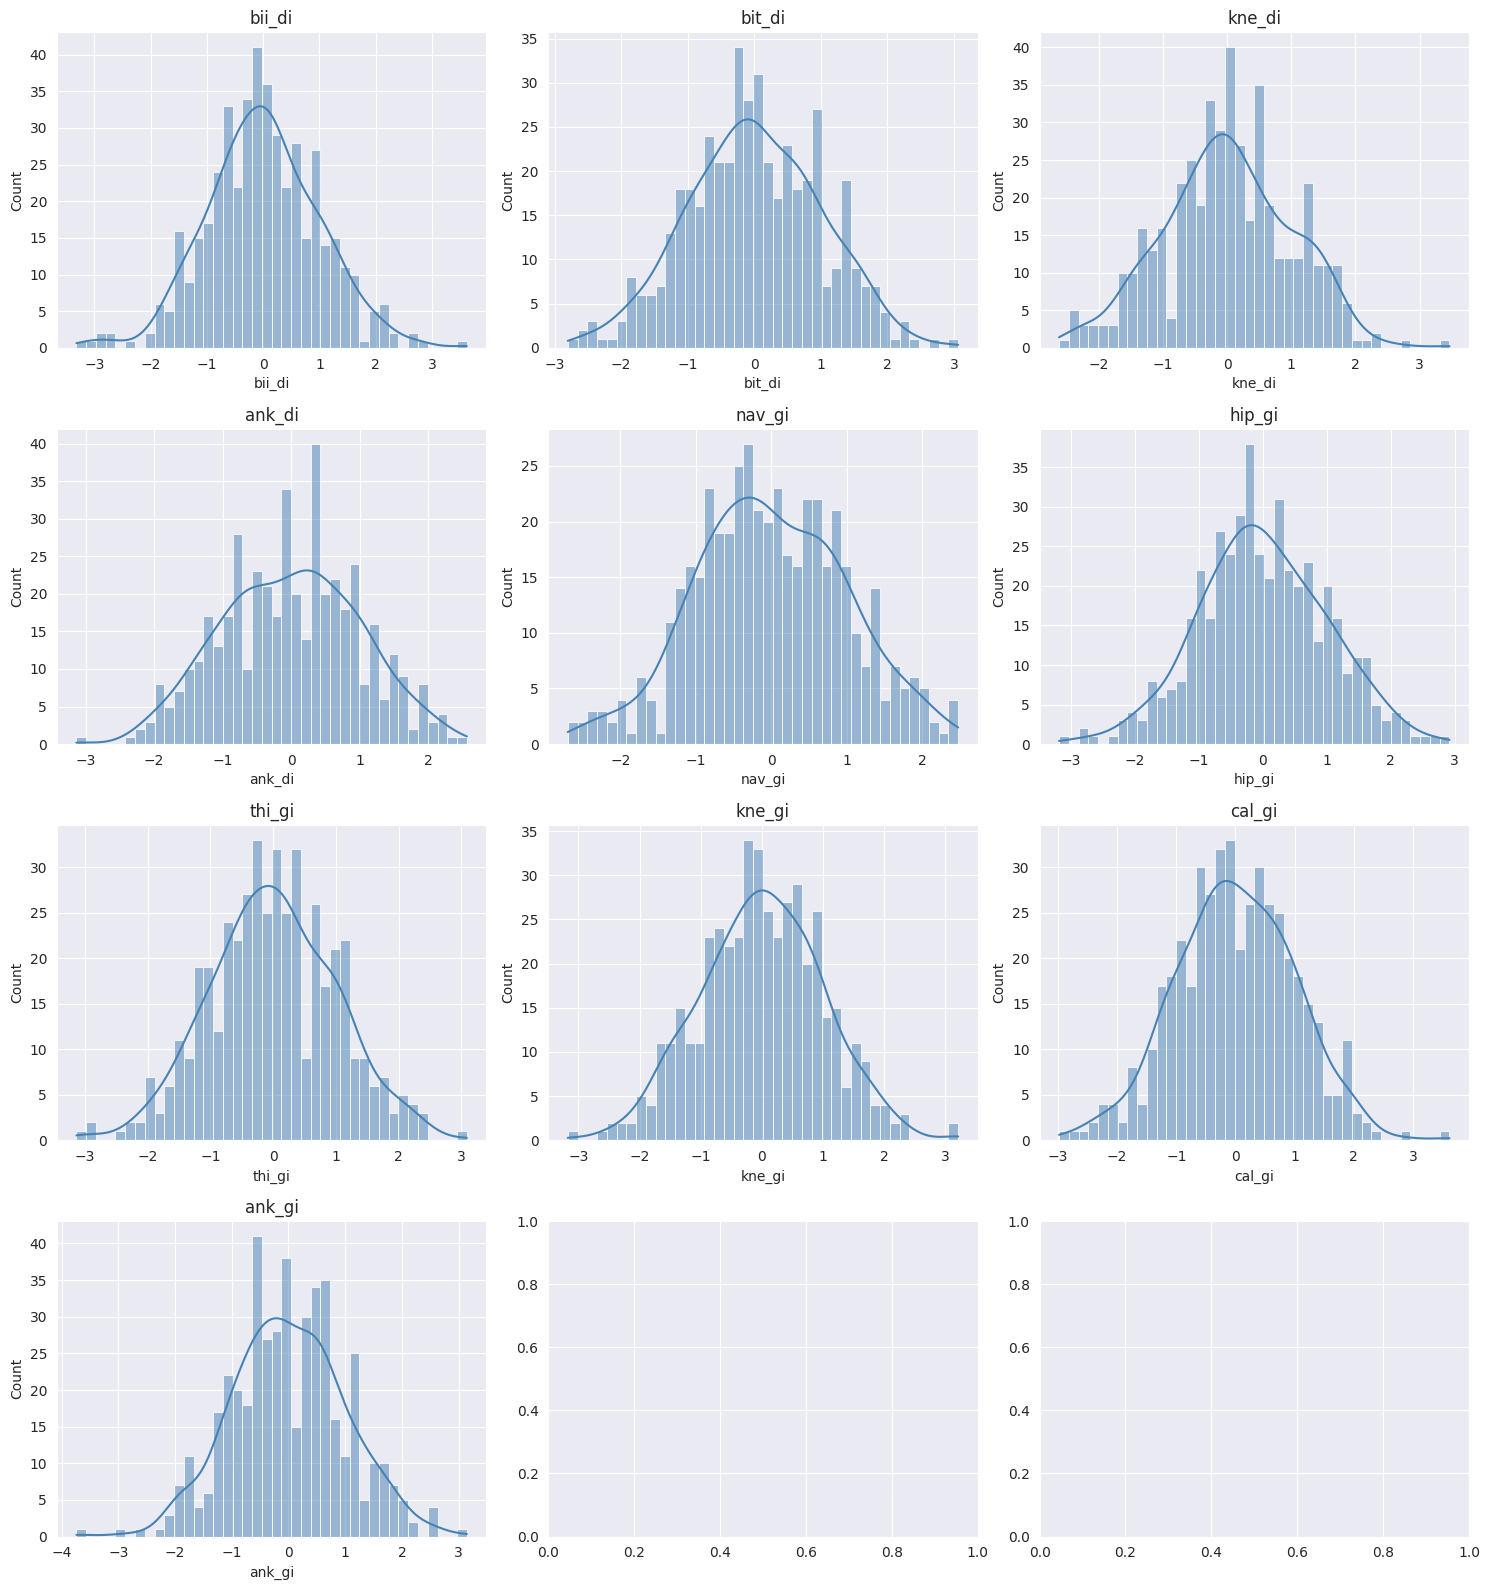

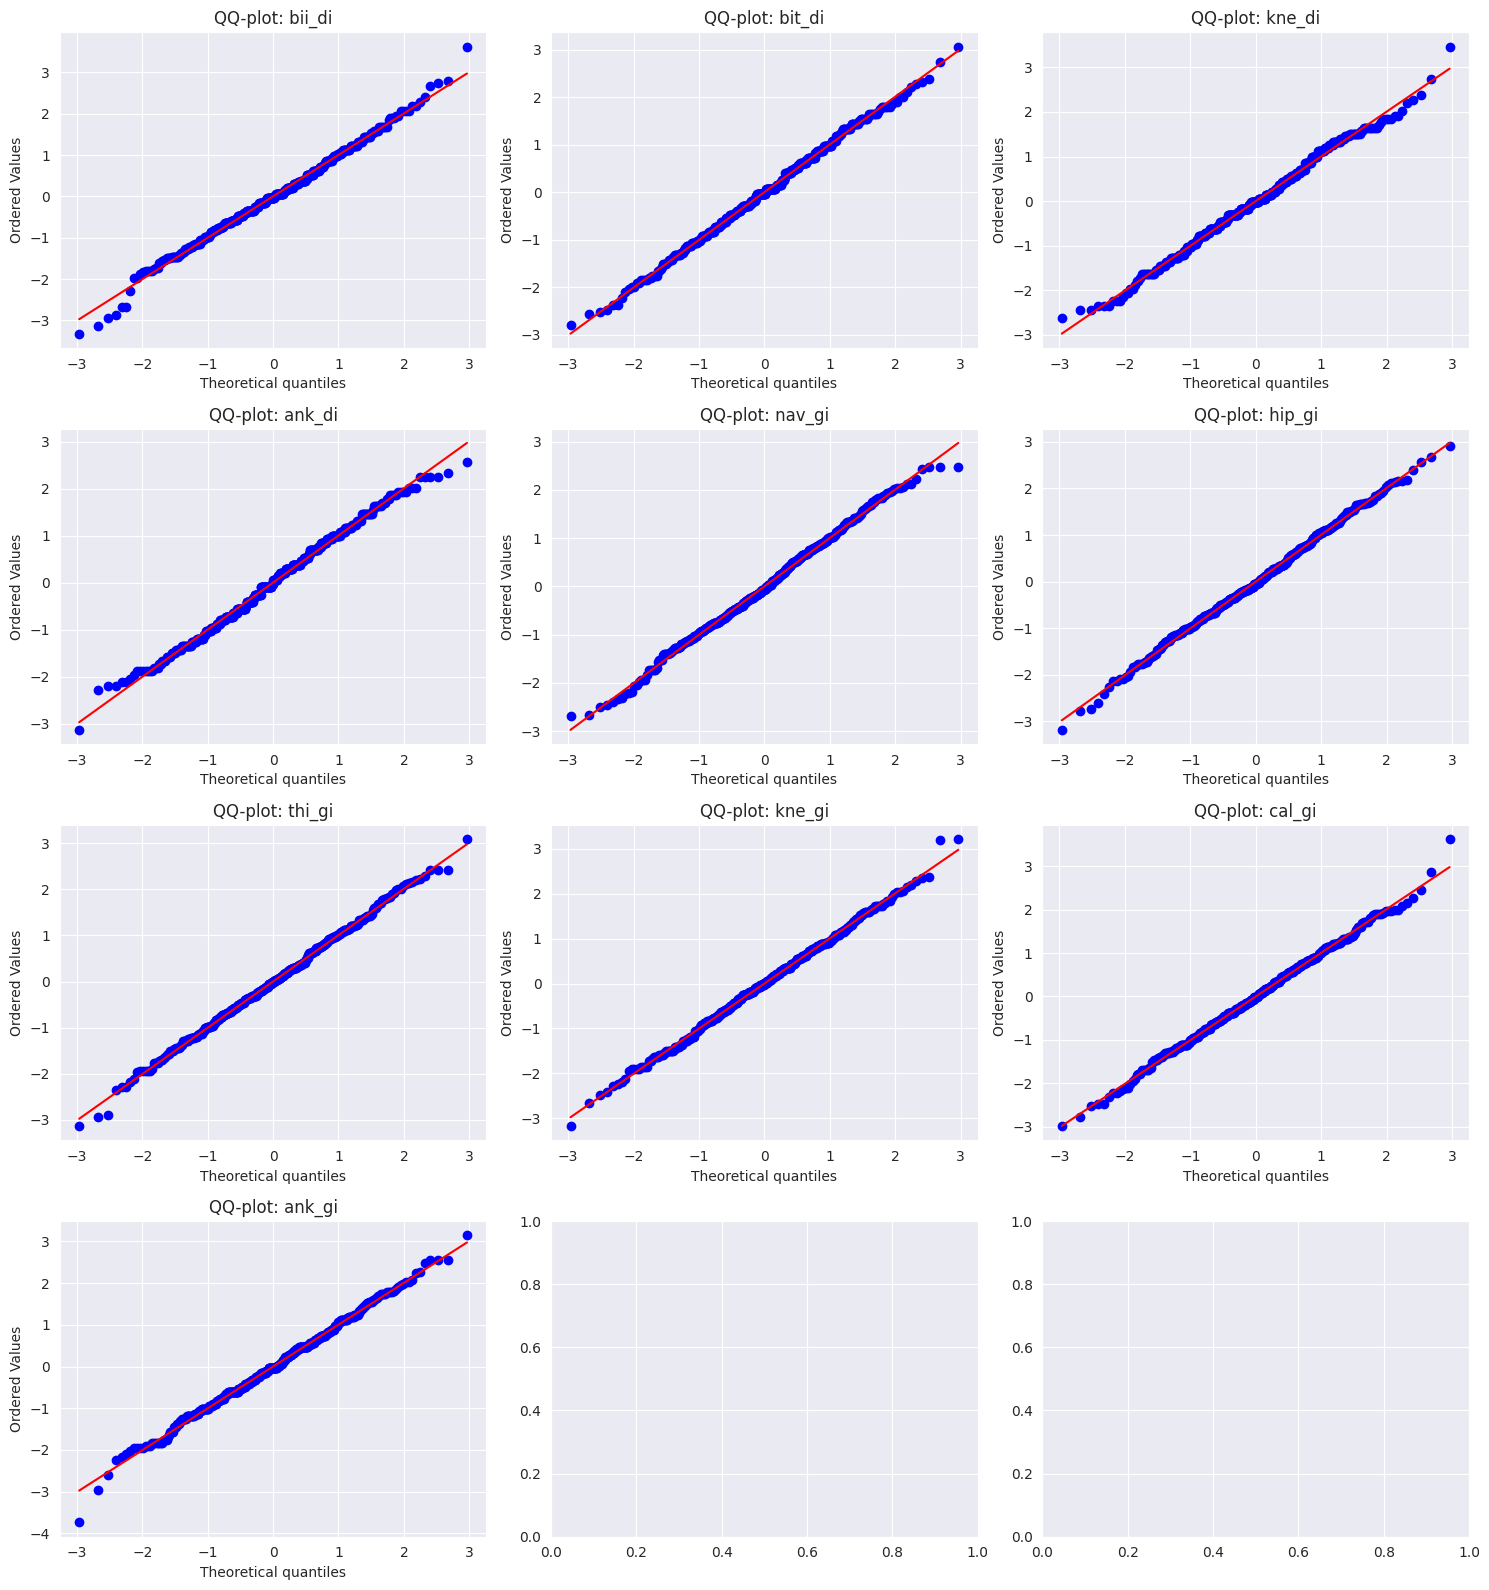

In [53]:
plot_distributions(df_train, df_train.columns)


# Step 2: Check Correlations

In [58]:
s1 = ['number_of_mortgage_accounts','total_credit_limit','balance_excl_mortgage']
s2 = ['delinquencies_2yrs','interest_rate','number_of_mortgage_accounts']
s3 = ['total_credit_limit','interest_rate', 'annual_income']

sr = ['open_acc', 'total_acc', 'total_rec_int']
sr2 = ['open_acc', 'total_acc', 'acc_open_past_24mths']
sr3 = ['mo_sin_rcnt_tl', 'num_bc_tl', 'num_il_tl']

scenarios_lcd = [sr, sr2, sr3]

In [59]:
scenarios_heart = ['x']
scenarios_body = [['bii_di','ank_di','kne_gi']]

In [60]:
if name == 'accepted_2007_to_2018Q4.csv':
    scenarios = scenarios_lcd
elif name == 'heart.xls':
    scenarios = scenarios_heart
elif name =='dataset-310405444.csv':
    scenarios = scenarios_body
scenarios_dict = {i: {'columns': s, 'Original Multipole': None,
                      'Original transformed': None,
                      'Synthetic Multipole': None}
                  for i, s in enumerate(scenarios)}

# pairwise correlations:

for i, s in enumerate(scenarios):
    corr_matrix = df_train_org[s].corr(method='pearson')
    print(f"Scenario {i + 1}")
    print("Pairwise correlation matrix")
    display(corr_matrix)
    multipole_val_trans = compute_multipole(df_train_org, s, method='pearson')
    multipole_val = compute_multipole(df_train, s, method="pearson")
    
    scenarios_dict[i]['Original Multipole'] = multipole_val
    scenarios_dict[i]['Original transformed'] = multipole_val_trans
    print(f"Columns: {s}, Multipole: {multipole_val:.4f}")
    print(f"Columns: {s}, Multipole transformed: {multipole_val_trans:.4f}")
    
    
    print("\n")

Scenario 1
Pairwise correlation matrix


,bii_di,ank_di,kne_gi
bii_di,1.000000,0.383762,0.458590
ank_di,0.383762,1.000000,0.565026
kne_gi,0.458590,0.565026,1.000000


Columns: ['bii_di', 'ank_di', 'kne_gi'], Multipole: 0.5838
Columns: ['bii_di', 'ank_di', 'kne_gi'], Multipole transformed: 0.5756


# Step 3: Fit GCM and Generate Synthetic Data

In [62]:
# 1. Initialize the GCM model and fit it to your source data
gcm = GCM()
gcm.fit(df_train)

# # 2. Generate synthetic samples
synthetic_data = pd.DataFrame(gcm.sample(num_samples=50000), columns=df_train.columns)

# 3. Verify that the correlation structure is preserved
corr_real = np.corrcoef(df_train_org, rowvar=False)
corr_real_trans = np.corrcoef(df_train, rowvar=False)
corr_synth = np.corrcoef(synthetic_data, rowvar=False)

synthetic_data.head()

,bii_di,bit_di,kne_di,ank_di,nav_gi,hip_gi,thi_gi,kne_gi,cal_gi,ank_gi
0,0.230825,-0.010228,0.042569,0.052021,-0.161446,0.173480,0.498870,-0.264804,0.386588,0.019681
1,-2.802770,-1.146105,-0.107514,0.313290,0.169030,-0.353981,0.324745,0.023059,0.234556,0.876372
2,-1.438050,-0.575619,-0.904795,-0.634262,-0.325710,-0.575416,-0.131700,-1.435048,-1.626339,-1.196835
3,1.838311,0.988807,0.817837,0.343159,0.916357,1.418418,1.841821,1.373320,1.086730,0.056651
4,0.317994,-2.049420,0.432638,0.252833,-0.200486,-0.569835,-0.065812,-0.083305,0.226795,-0.317923


In [64]:
# # Compute mean and std from normally distributed original training data
# means = df_train_org.mean()
# stds = df_train_org.std()
# 
# # Rescale synthetic data
# synthetic_rescaled = synthetic_data * stds + means
# 
# # Keep as DataFrame with same columns
# synthetic_rescaled = pd.DataFrame(synthetic_rescaled, columns=df_train_org.columns)
# corr_synth_rescaled = np.corrcoef(synthetic_rescaled, rowvar=False)

synth_inv_trans = pd.DataFrame(pt.inverse_transform(synthetic_data), columns =  df_train.columns)
corr_synth_inv_trans = np.corrcoef(synth_inv_trans, rowvar=False)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- age
- bia_di
- bic_gi
- che_de
- che_di
- ...


In [65]:
synthetic_data.isna()

,bii_di,bit_di,kne_di,ank_di,nav_gi,hip_gi,thi_gi,kne_gi,cal_gi,ank_gi
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
49995,False,False,False,False,False,False,False,False,False,False
49996,False,False,False,False,False,False,False,False,False,False
49997,False,False,False,False,False,False,False,False,False,False
49998,False,False,False,False,False,False,False,False,False,False


In [66]:
synth_inv_trans.isna()

,open_acc,total_acc,total_rec_int,acc_open_past_24mths,mo_sin_rcnt_tl,num_bc_tl,num_il_tl,num_op_rev_tl,num_sats
0,False,False,False,False,True,False,False,False,False
1,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
49995,False,False,False,False,False,False,False,False,False
49996,False,False,False,False,False,False,False,False,False
49997,False,False,False,False,False,False,False,False,False
49998,False,False,False,False,False,False,False,False,False


# Step 4: Validate Results

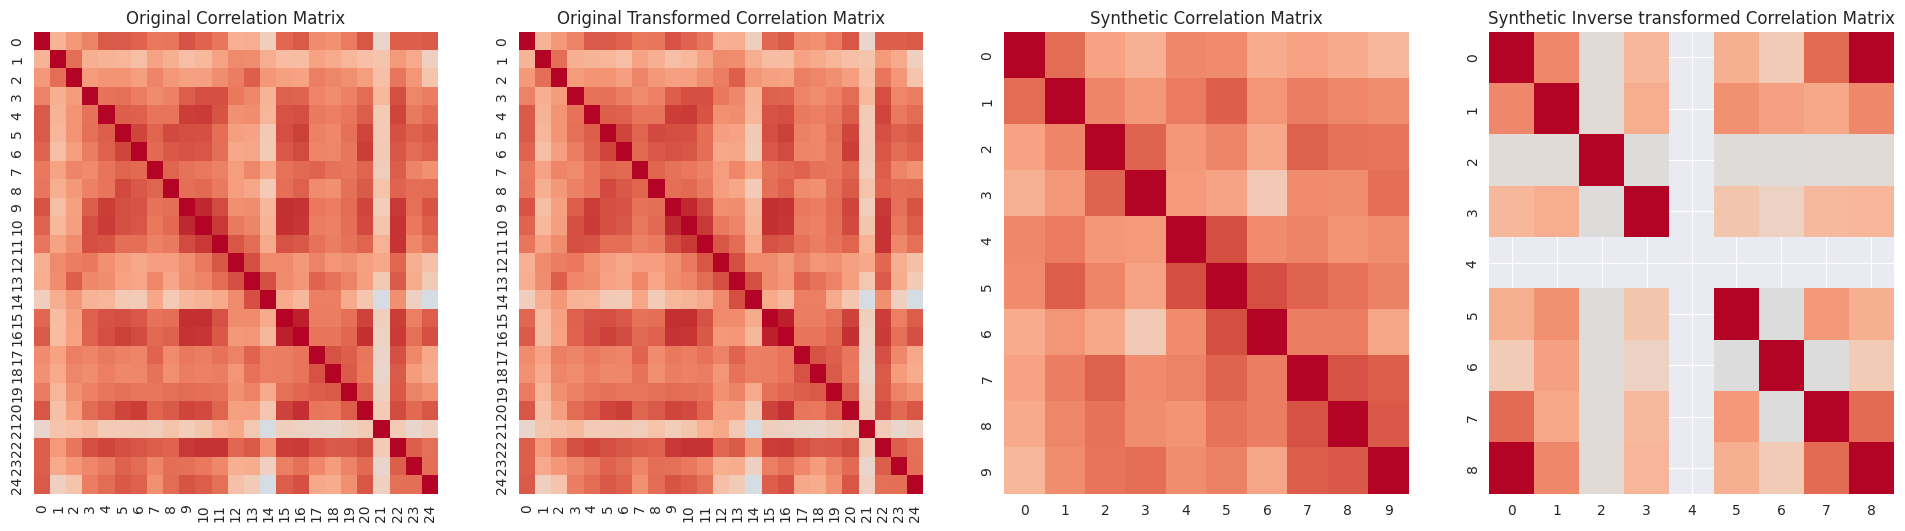

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 4, figsize=(24,6))

sns.heatmap(corr_real, ax=axes[0], cmap="coolwarm", center=0, cbar=False)
axes[0].set_title("Original Correlation Matrix")
sns.heatmap(corr_real, ax=axes[1], cmap="coolwarm", center=0, cbar=False)
axes[1].set_title("Original Transformed Correlation Matrix")
sns.heatmap(corr_synth, ax=axes[2], cmap="coolwarm", center=0, cbar=False)
axes[2].set_title("Synthetic Correlation Matrix")
sns.heatmap(corr_synth_inv_trans, ax=axes[3], cmap="coolwarm", center=0, cbar=False)
axes[3].set_title("Synthetic Inverse transformed Correlation Matrix")
plt.show()


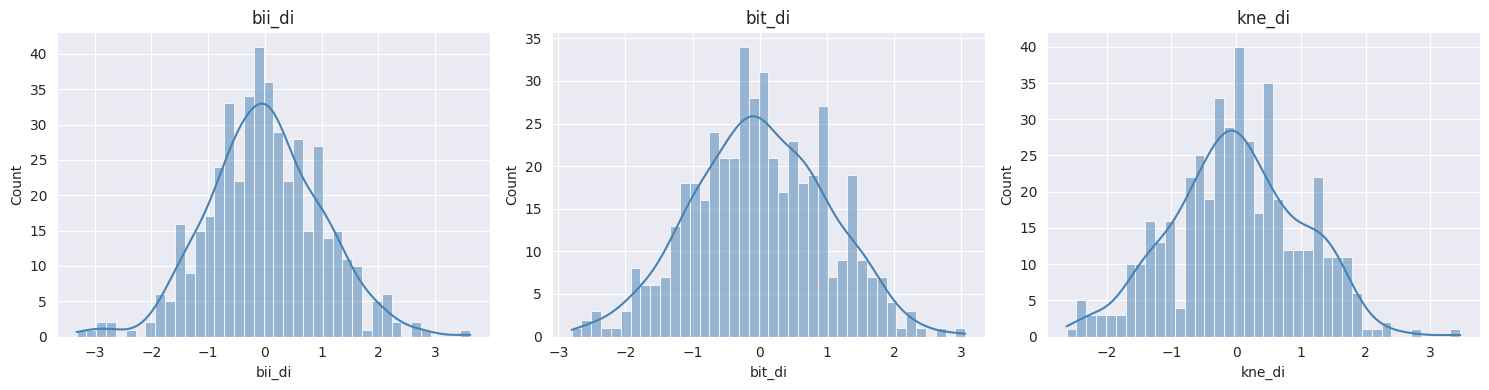

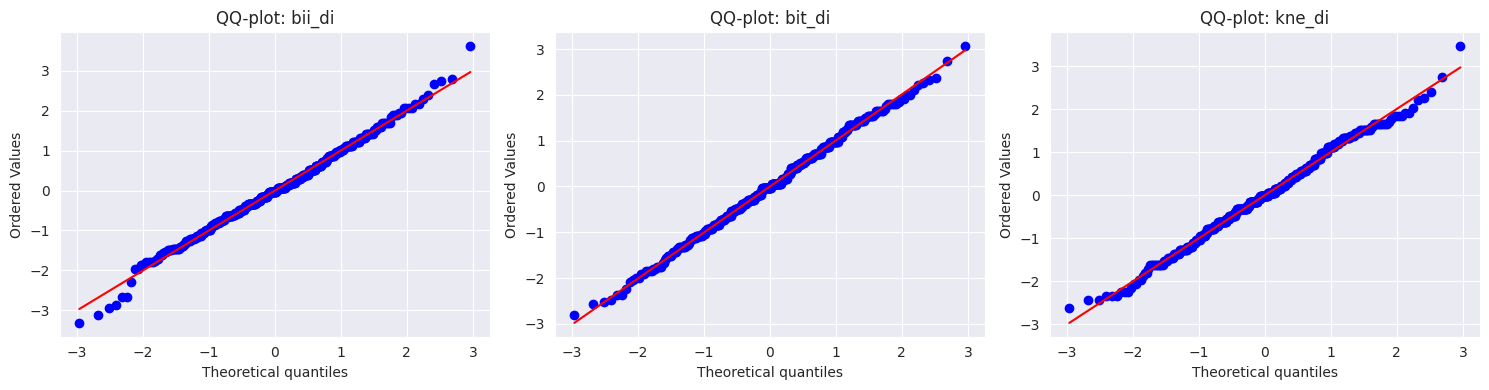

In [68]:
plot_distributions(df_train, synthetic_data.columns[:3])

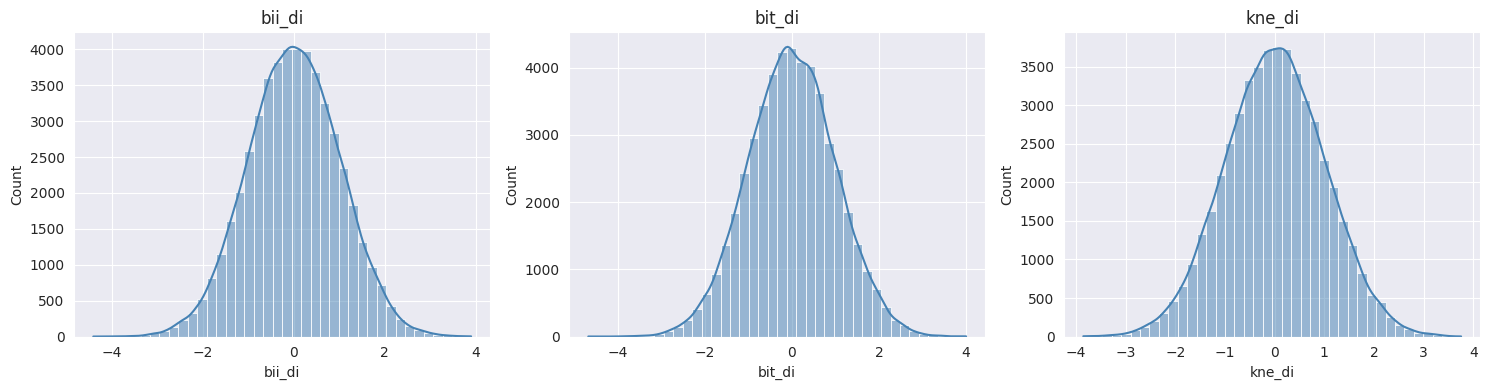

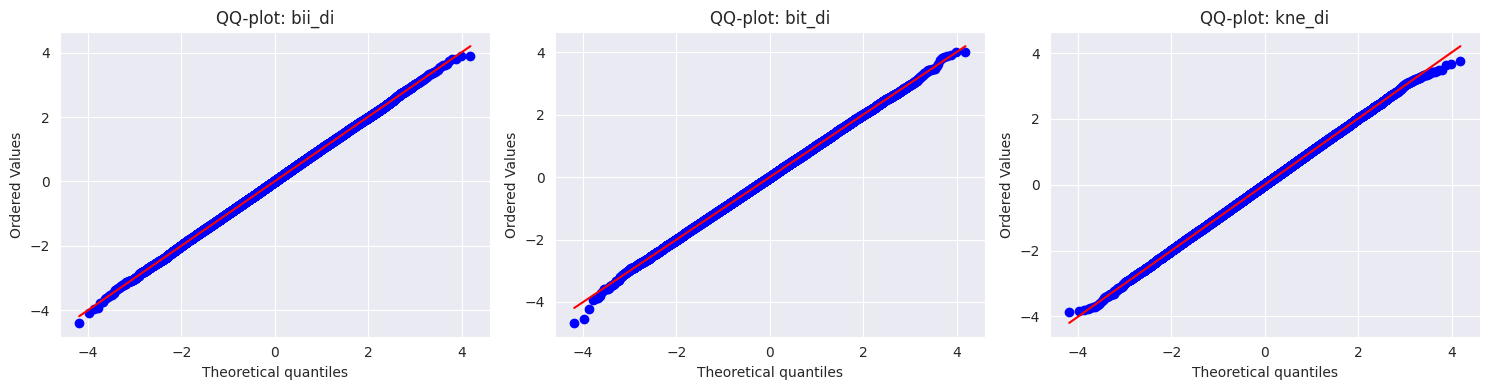

In [69]:
plot_distributions(synthetic_data, df_train.columns[:3])

In [70]:
# Are the multipoles preserved?
for i, s in enumerate(scenarios):
    scenarios_dict[i]['Synthetic Multipole'] = compute_multipole(pd.DataFrame(synthetic_data, columns=df_train_org.columns), s, method="pearson")
    scenarios_dict[i]['Synthetic InvTrans Multipole'] = compute_multipole(pd.DataFrame(synth_inv_trans, columns=df_train_org.columns), s, method="pearson")
    
    
# Convert to DataFrame
results = pd.DataFrame.from_dict(scenarios_dict, orient='index')

# Format numeric columns nicely
numeric_cols = ['Original Multipole','Original transformed', 'Synthetic Multipole','Synthetic InvTrans Multipole']
results[numeric_cols] = results[numeric_cols].applymap(lambda x: f"{x:.4f}" if x is not None else "-")
display(results)


LinAlgError: Eigenvalues did not converge

### Correlations are almost preserved. Definitely up until the scaled synthetic data that is still normally distributed. After detransforming it to the original distribution, the multivariate correlations are close, but significantly off.

# Step 5: Downstream task analysis

,open_acc,total_acc,total_rec_int,acc_open_past_24mths,mo_sin_rcnt_tl,num_bc_tl,num_il_tl,num_op_rev_tl,num_sats
0,7.0,13.0,821.72,4.0,3.0,5.0,3.0,4.0,7.0
1,22.0,38.0,979.66,4.0,2.0,17.0,6.0,20.0,22.0
2,6.0,18.0,2705.92,6.0,14.0,4.0,6.0,4.0,6.0
3,13.0,17.0,12361.66,2.0,2.0,10.0,2.0,10.0,13.0
4,12.0,35.0,1340.50,10.0,4.0,9.0,10.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...
8995,15.0,41.0,3441.26,4.0,7.0,12.0,9.0,13.0,15.0
8996,17.0,26.0,2936.96,6.0,4.0,6.0,9.0,11.0,17.0
8997,16.0,25.0,2547.05,5.0,12.0,6.0,10.0,8.0,16.0
8998,7.0,8.0,794.57,2.0,3.0,4.0,3.0,4.0,7.0


In [37]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Features and target
features = ['open_acc', 'total_rec_int', 'acc_open_past_24mths',
       'mo_sin_rcnt_tl', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl']
target = 'total_acc'

X_train = df_train_org[features]
y_train = df_train_org[target]

X_synth_resc = synthetic_data[features]
y_synth_resc = synthetic_data[target]

# X_synth = synth_inv_trans[features]
# y_synth = synth_inv_trans[target]

X_test = df_test[features]
y_test = df_test[target]

# Train models
reg_org = LinearRegression().fit(X_train, y_train)
# reg_synth = LinearRegression().fit(X_synth, y_synth)
reg_synth_resc = LinearRegression().fit(X_synth_resc, y_synth_resc)


# Evaluate on the same held-out test set
y_pred_org = reg_org.predict(X_test)
# y_pred_synth = reg_synth.predict(X_test)
y_pred_synth_resc = reg_synth_resc.predict(X_test)


metrics = {
    "R2_org": r2_score(y_test, y_pred_org),
    "MSE_org": mean_squared_error(y_test, y_pred_org),
    "R2_synth_resc": r2_score(y_test, y_pred_synth_resc),
    "MSE_synth_resc": mean_squared_error(y_test, y_pred_synth_resc),
    # "R2_synth": r2_score(y_test, y_pred_synth),
    # "MSE_synth": mean_squared_error(y_test, y_pred_synth)
}

print(metrics)

{'R2_org': 0.8746321766113988, 'MSE_org': 18.45988244028554, 'R2_synth_resc': 0.874728829604648, 'MSE_synth_resc': 18.445650695291828}


In [38]:
reg_org.coef_

array([-1.57238334e-03,  3.43015958e-05,  7.13300017e-02, -2.05506053e-02,
        1.04616306e+00,  1.05146072e+00,  7.23441894e-01])

In [39]:
reg_org.intercept_

1.5355875713084473

In [40]:
reg_synth_resc.coef_

array([ 6.81922632e-03,  4.06981312e-05,  7.54494744e-02, -2.03441753e-02,
        1.05209010e+00,  1.04697646e+00,  7.12620398e-01])

In [41]:
reg_synth_resc.intercept_

1.4749384623705595

[1 6 3 4 2 5 1]
[1 6 3 4 2 5 1]

=== Correlation Matrix Similarity ===
Frobenius norm diff: 0.0160
Correlation of upper triangles: 1.0000

=== PCA Comparison ===
Explained variance ratio (first 5 comps):
  PC1: real=1.000, synth=1.000
  PC2: real=0.000, synth=0.000
  PC3: real=0.000, synth=0.000
  PC4: real=0.000, synth=0.000
  PC5: real=0.000, synth=0.000
Principal angles (radians): [0. 0. 0. 0. 0.]

=== Feature Clustering ===
                Feature  Cluster_real  Cluster_synth
0              open_acc             1              1
1         total_rec_int             6              6
2  acc_open_past_24mths             3              3
3        mo_sin_rcnt_tl             4              4
4             num_bc_tl             2              2
5             num_il_tl             5              5
6         num_op_rev_tl             1              1


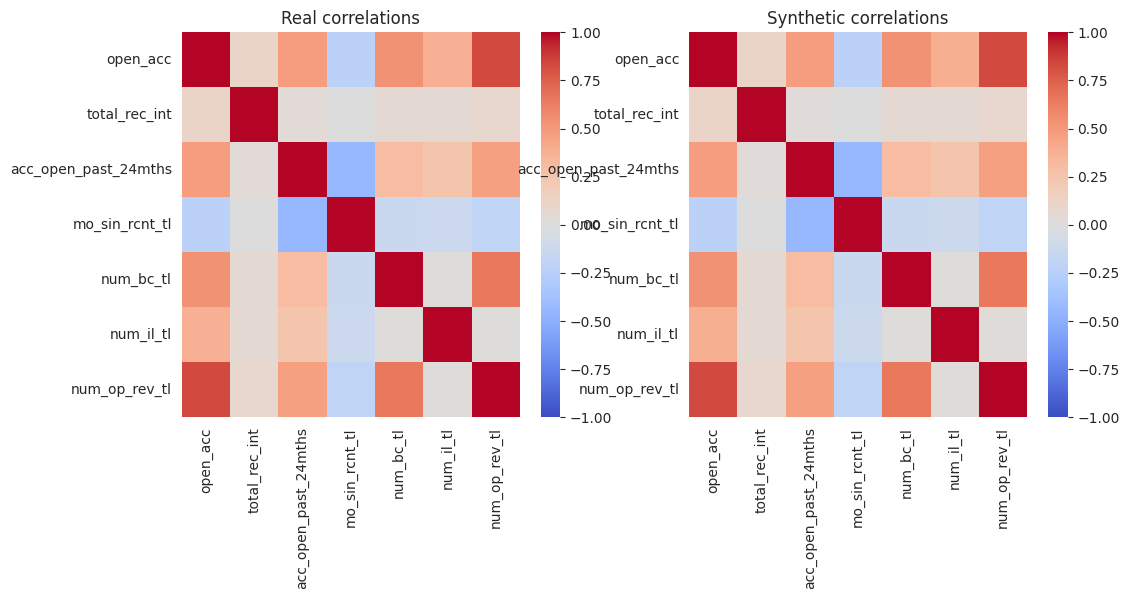

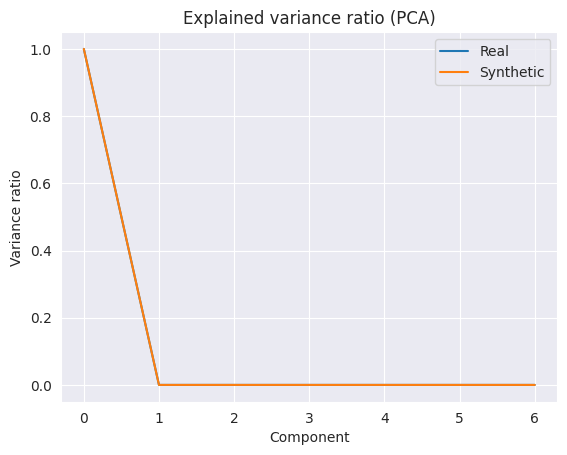

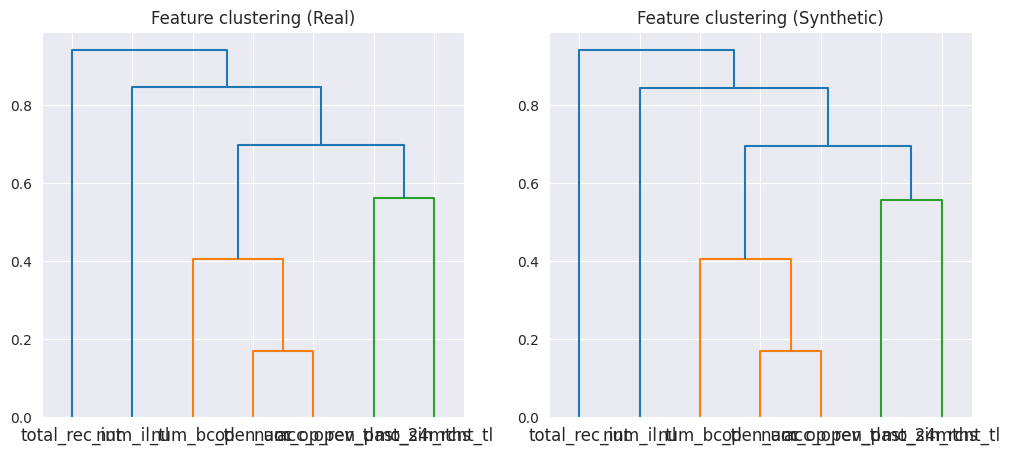

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from numpy.linalg import svd, norm

# -----------------------------
# CONFIG: select numeric features
# -----------------------------

# 
# X_real = df_train[features].dropna()
# X_synth = synthetic_data[features].dropna()

# -----------------------------
# 1. Correlation matrix similarity
# -----------------------------
corr_real = X_train.corr()
corr_synth = X_synth_resc.corr()

# Frobenius norm of difference
fro_diff = norm(corr_real.values - corr_synth.values, ord='fro')
# correlation of upper triangles
tri_real = corr_real.where(np.triu(np.ones(corr_real.shape), k=1).astype(bool)).stack()
tri_synth = corr_synth.where(np.triu(np.ones(corr_synth.shape), k=1).astype(bool)).stack()
tri_corr = np.corrcoef(tri_real, tri_synth)[0, 1]

# -----------------------------
# 2. PCA comparison
# -----------------------------
pca_r = PCA().fit(X_train)
pca_s = PCA().fit(X_synth_resc)

# Explained variance
explained_real = pca_r.explained_variance_ratio_
explained_synth = pca_s.explained_variance_ratio_

# Principal angles between subspaces (via SVD of UᵀV)
U = pca_r.components_.T
V = pca_s.components_.T
M = U.T.dot(V)
svals = svd(M, compute_uv=False)
angles = np.arccos(np.clip(svals, -1, 1))

# -----------------------------
# 3. Feature clustering (hierarchical on correlations)
# -----------------------------
def feature_clusters(corr, threshold=0.7):
    # distance = 1 - |corr|
    dist = 1 - np.abs(corr)
    linkage_mat = linkage(squareform(dist, checks=False), method='average')
    clusters = fcluster(linkage_mat, t=1-threshold, criterion='distance')
    return clusters, linkage_mat

clusters_real, link_real = feature_clusters(corr_real)
clusters_synth, link_synth = feature_clusters(corr_synth)


print(clusters_real)
print(clusters_synth)
# Put into dataframe
cluster_df = pd.DataFrame({
    "Feature": features,
    "Cluster_real": clusters_real,
    "Cluster_synth": clusters_synth
})

# -----------------------------
# Summary output
# -----------------------------
print("\n=== Correlation Matrix Similarity ===")
print(f"Frobenius norm diff: {fro_diff:.4f}")
print(f"Correlation of upper triangles: {tri_corr:.4f}")

print("\n=== PCA Comparison ===")
print("Explained variance ratio (first 5 comps):")
for i in range(5):
    print(f"  PC{i+1}: real={explained_real[i]:.3f}, synth={explained_synth[i]:.3f}")
print("Principal angles (radians):", np.round(angles[:5], 3))

print("\n=== Feature Clustering ===")
print(cluster_df)

# -----------------------------
# Visualizations
# -----------------------------
# Heatmaps
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(corr_real, vmin=-1, vmax=1, cmap="coolwarm", center=0, annot=False)
plt.title("Real correlations")
plt.subplot(1,2,2)
sns.heatmap(corr_synth, vmin=-1, vmax=1, cmap="coolwarm", center=0, annot=False)
plt.title("Synthetic correlations")
plt.show()

# PCA explained variance
plt.plot(explained_real, label="Real")
plt.plot(explained_synth, label="Synthetic")
plt.title("Explained variance ratio (PCA)")
plt.xlabel("Component")
plt.ylabel("Variance ratio")
plt.legend()
plt.show()

# Dendrograms
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
dendrogram(link_real, labels=features)
plt.title("Feature clustering (Real)")
plt.subplot(1,2,2)
dendrogram(link_synth, labels=features)
plt.title("Feature clustering (Synthetic)")
plt.show()
